# Learning Reachability

In [47]:
# Preamble.
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from matplotlib import pyplot as plt

from labm8 import viz

from experimental.compilers.reachability import control_flow_graph as cfg
from experimental.compilers.reachability import control_flow_graph_generator as cfg_generator

%matplotlib inline

In [35]:
# Plotting utils.

def GetName(g, n, label_entry_and_exit = True) -> str:
    if label_entry_and_exit:
        if g.nodes[n].get('entry', False):
            return 'Entry'
        if g.nodes[n].get('exit', False):
            return 'Exit'
    return g.nodes[n]['name']
    
def DrawGraph(g: cfg.ControlFlowGraph, ax=None, label_entry_and_exit = True) -> None:
    ax = ax or plt.gca()
    nx.draw_spring(g, labels={n: GetName(g, n, label_entry_and_exit) for n in g.nodes}, node_size=600)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

## Generating Random CFGs

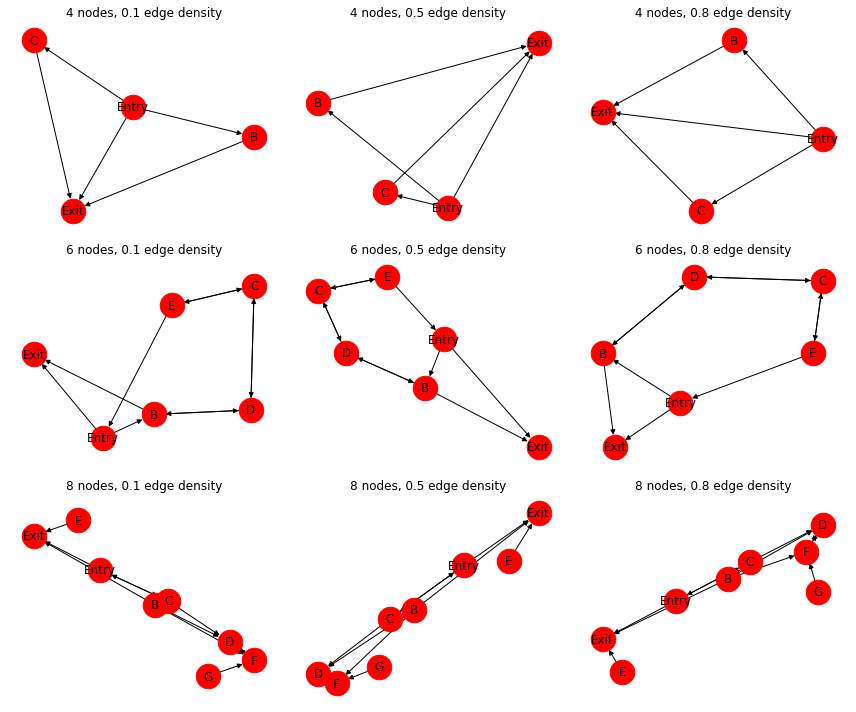

In [48]:
# Parameter sweep to draw a grid of basic blocks.
num_nodes = [4, 6, 8]
edge_densities = [0.1, 0.5, 0.8]

fig = plt.figure(figsize=(int(4 * len(edge_densities)), int(3.5 * len(num_nodes))))
fig.clf()

for j, n in enumerate(num_nodes):
    for i, ed in enumerate(edge_densities):
        ax_index = (j * len(edge_densities)) + i + 1
        ax = fig.add_subplot(len(num_nodes), len(edge_densities), ax_index)
        # Generate a graph with the requested num blocks and edge density. Use the
        # same random seed per row.
        graph = next(cfg_generator.ControlFlowGraphGenerator(
            np.random.RandomState(j), (n, n), ed))
        DrawGraph(graph, ax=ax)
        ax.set_title(f'{n} nodes, {ed} edge density')

viz.finalise()

## CFG Reachabilities

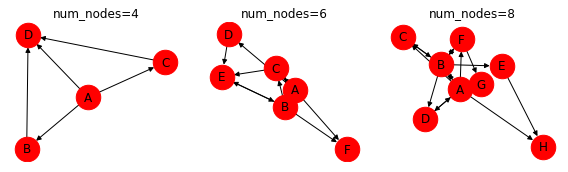

A  B  C  D  E  F  G  H
num_nodes src                        
4         A    ✘  ✓  ✓  ✓            
          B    ✘  ✘  ✘  ✓            
          C    ✘  ✘  ✘  ✓            
          D    ✘  ✘  ✘  ✘            
6         A    ✘  ✓  ✓  ✓  ✓  ✓      
          B    ✓  ✘  ✓  ✓  ✓  ✓      
          C    ✓  ✓  ✘  ✓  ✓  ✓      
          D    ✓  ✓  ✓  ✘  ✓  ✓      
          E    ✓  ✓  ✓  ✓  ✘  ✓      
          F    ✘  ✘  ✘  ✘  ✘  ✘      
8         A    ✘  ✓  ✓  ✓  ✓  ✓  ✓  ✓
          B    ✓  ✘  ✓  ✓  ✓  ✓  ✓  ✓
          C    ✓  ✓  ✘  ✓  ✓  ✓  ✓  ✓
          D    ✓  ✓  ✓  ✘  ✓  ✓  ✓  ✓
          E    ✘  ✘  ✘  ✘  ✘  ✘  ✘  ✓
          F    ✓  ✓  ✓  ✓  ✓  ✘  ✓  ✓
          G    ✓  ✓  ✓  ✓  ✓  ✓  ✘  ✓
          H    ✘  ✘  ✘  ✘  ✘  ✘  ✘  ✘

In [49]:
def BinArray(array):
    return ['✓' if x else '✘' for x in array]

fig = plt.figure(figsize=(8, 2.5))
fig.clf()

num_nodes = [4, 6, 8]

g = cfg_generator.UniqueNameSequence('A')
node_names = [g for g, _ in zip(g, range(max(num_nodes)))]
edge_density = 0.01
rows = []
for i, n in enumerate(num_nodes):
    graph = next(cfg_generator.ControlFlowGraphGenerator(
            np.random.RandomState(0), (n, n), edge_density))
    ax = fig.add_subplot(1, 3, i + 1)
    DrawGraph(graph, ax=ax, label_entry_and_exit=False)
    ax.set_title(f'num_nodes={n}')
    for node in graph.nodes:
        rows.append([graph.number_of_nodes(), node_names[node]] + 
                    BinArray(graph.Reachables(node)) + 
                    [''] * (max(num_nodes) - len(graph.nodes)))

viz.finalise()
df = pd.DataFrame(rows, columns = ['num_nodes', 'src'] + node_names)
df.set_index(['num_nodes', 'src'], inplace=True)
df

## Proportion of Basic Blocks that are Reachable

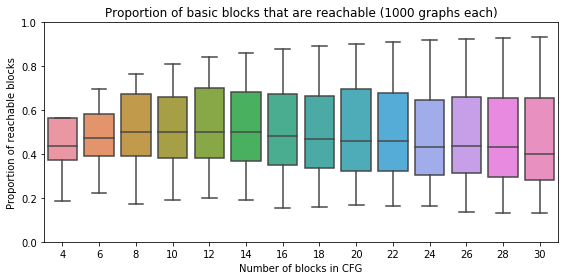

In [69]:
num_nodes = list(range(4, 31, 2))
edge_density = 0.1
num_graphs = 1000

rows = []
for i, n in enumerate(num_nodes):
    generator = cfg_generator.ControlFlowGraphGenerator(
        np.random.RandomState(0), (n, n), edge_density)
    graphs = [g for g, _ in zip(generator, range(num_graphs))]
    for graph in graphs:
        num_reachable = sum(sum(graph.Reachables(node)) for node in graph.nodes)
        rows.append((n, num_reachable / (graph.number_of_nodes() * graph.number_of_nodes())))

df = pd.DataFrame(rows, columns=['num_nodes', 'reachability_density'])

sns.boxplot(x='num_nodes', y='reachability_density', data=df)
plt.xlabel('Number of blocks in CFG')
plt.ylabel('Proportion of reachable blocks')
plt.title(f'Proportion of basic blocks that are reachable ({num_graphs} graphs each)')
plt.ylim((0, 1))
viz.finalise(figsize=(8, 4))